In [178]:
# helper functions
def get_rot_x(angle):
    '''
    transformation matrix that rotates a point about the standard X axis
    '''
    Rx = np.zeros(shape=(3, 3))
    Rx[0, 0] = 1
    Rx[1, 1] = np.cos(angle)
    Rx[1, 2] = -np.sin(angle)
    Rx[2, 1] = np.sin(angle)
    Rx[2, 2] = np.cos(angle)
    
    return Rx

def get_rot_y(angle):
    '''
    transformation matrix that rotates a point about the standard Y axis
    '''
    Ry = np.zeros(shape=(3, 3))
    Ry[0, 0] = np.cos(angle)
    Ry[0, 2] = -np.sin(angle)
    Ry[2, 0] = np.sin(angle)
    Ry[2, 2] = np.cos(angle)
    Ry[1, 1] = 1
    
    return Ry

def get_rot_z(angle):
    '''
    transformation matrix that rotates a point about the standard Z axis
    '''
    Rz = np.zeros(shape=(3, 3))
    Rz[0, 0] = np.cos(angle)
    Rz[0, 1] = -np.sin(angle)
    Rz[1, 0] = np.sin(angle)
    Rz[1, 1] = np.cos(angle)
    Rz[2, 2] = 1
    
    return Rz

def create_rotation_transformation_matrix(angles, order):
    '''
    Create a matrix that rotates a vector through the given angles in the given order
    wrt the standard global axes (extrinsic rotation)
    Note: The rotation is carried out anti-clockwise in a left handed axial system
    
    Parameters
    -----------
    angles - list
        list of angles in radians
    order - string
        the order in which to rotate
        
    Returns
    --------
    net - np.ndarray, shape - (3, 3)
        The transformation matrix which carries out the given rotations
    '''
    fn_mapping = {'x': get_rot_x, 'y': get_rot_y, 'z': get_rot_z}
    net = np.identity(3)
    for angle, axis in list(zip(angles, order))[::-1]:
        if fn_mapping.get(axis) is None:
            raise ValueError("Invalid axis")
        R = fn_mapping.get(axis)
        net = np.matmul(net, R(angle))
        
    return net

In [184]:
M = np.asarray([[0, 1, 0],
            [0, 0, -1],
            [-1, 0, 0]])

In [179]:
angles = [np.pi/4]
order = ['y']
Y = create_rotation_transformation_matrix(angles, order)
Y

array([[ 0.70710678,  0.        , -0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.70710678,  0.        ,  0.70710678]])

In [180]:
angles = [1]
order = ['x']
X = create_rotation_transformation_matrix(angles, order)
X

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54030231, -0.84147098],
       [ 0.        ,  0.84147098,  0.54030231]])

In [181]:
angles = [1]
order = ['z']
Z = create_rotation_transformation_matrix(angles, order)
Z

array([[ 0.54030231, -0.84147098,  0.        ],
       [ 0.84147098,  0.54030231,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [185]:
M @ X @ Y @ Z

array([[ 0.13316353,  0.7926101 , -0.59500984],
       [-0.91449668, -0.13316353, -0.38205142],
       [-0.38205142,  0.59500984,  0.70710678]])

In [165]:
R.from_euler('x', x).as_matrix()

array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.54030231, -0.84147098],
       [ 0.        ,  0.84147098,  0.54030231]])

In [188]:
X @ Y @ Z

array([[ 0.38205142, -0.59500984, -0.70710678],
       [ 0.13316353,  0.7926101 , -0.59500984],
       [ 0.91449668,  0.13316353,  0.38205142]])

In [166]:
R.from_euler('y', y).as_matrix()

array([[ 0.70710678,  0.        ,  0.70710678],
       [ 0.        ,  1.        ,  0.        ],
       [-0.70710678,  0.        ,  0.70710678]])

In [167]:
R.from_euler('z', z).as_matrix()

array([[ 0.54030231, -0.84147098,  0.        ],
       [ 0.84147098,  0.54030231,  0.        ],
       [ 0.        ,  0.        ,  1.        ]])

In [174]:
np.matmul(np.matmul(Z, Y), X)

array([[ 0.38205142, -0.7761339 ,  0.50165015],
       [ 0.59500984, -0.20875693, -0.7761339 ],
       [ 0.70710678,  0.59500984,  0.38205142]])

In [182]:
R.from_euler('xyz', [z, y, x]).as_matrix()

array([[ 0.38205142, -0.13316353,  0.91449668],
       [ 0.59500984,  0.7926101 , -0.13316353],
       [-0.70710678,  0.59500984,  0.38205142]])

# # 모듈 및 함수
---

In [1]:
import open3d as o3d
import numpy as np
import cv2
import torch
import pandas as pd
import re
import pickle as pkl
import json
import glob
import shutil
import os
from sklearn.model_selection import train_test_split
from scipy.spatial.transform import Rotation as R


# 문자열 숫자리스트로 바꾸는 함수
def str2list(txt):
    txt = txt.replace('\n', '').split(',')
    txt = list(map(float, txt))
    
    return txt


# 리스트를 문자열로 바꾸는 함수
def list2str(list):
    list = ' '.join(map(str, list))
    
    return list


# alpha 구하는 공식
import math

def normalizeAngle(angle):
    result = angle % (2*math.pi)
    if result < -math.pi:
        result += 2*math.pi
    elif result > math.pi:
        result -= 2*math.pi
    return result

def cal_alpha_ori(x, z, ry):  
    angle = ry
    angle -= -math.atan2(z, x) -1.5*math.pi 
    alpha = normalizeAngle(angle)
    return alpha # -1.818032754845337
# cal_alpha_ori(2.5702, 9.7190, -1.5595)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# # kitti dataset calib 확인
---

In [548]:
with open('/data/hwang/datasets/kitti/training/calib/000000.txt', 'r') as f:
    txt = f.readlines()

p0 = txt[0].replace('\n', '').split(' ')[1:] # 0번 카메라, projection matrix (= intrinsic * extrinsic)
p1 = txt[1].replace('\n', '').split(' ')[1:] # 1번 카메라
p2 = txt[2].replace('\n', '').split(' ')[1:] # 2번 카메라 (모델에 이 정보를 사용), (i, 4)위치는 기본 카메라와의 위상 차이 (각 x, y, z 축)
p3 = txt[3].replace('\n', '').split(' ')[1:] # 3번 카메라
R_rect = txt[4].replace('\n', '').split(' ')[1:] # 스테레오 카메라로 촬영 시 rotation matrix 보정 수치 (모노 카메라면 단위행렬 사용)
Tr_velo = txt[5].replace('\n', '').split(' ')[1:] # extrinsic (사용은 rigid body transformation 형태로 사용, extrinsic 4행에 [0, 0, 0, 1]을 추가)
Tr_imu = txt[6].replace('\n', '').split(' ')[1:]

print(np.around(np.asarray(p0, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p1, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p2, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p3, dtype=float).reshape(-1, 4), 1), '\n')
print(np.asarray(R_rect, dtype=float).reshape(-1, 3), '\n')
print(np.asarray(Tr_velo, dtype=float).reshape(-1, 4), '\n')
print(np.asarray(Tr_imu, dtype=float).reshape(-1, 4), '\n')

[[707.    0.  604.1   0. ]
 [  0.  707.  180.5   0. ]
 [  0.    0.    1.    0. ]] 

[[ 707.     0.   604.1 -379.8]
 [   0.   707.   180.5    0. ]
 [   0.     0.     1.     0. ]] 

[[ 7.070e+02  0.000e+00  6.041e+02  4.580e+01]
 [ 0.000e+00  7.070e+02  1.805e+02 -3.000e-01]
 [ 0.000e+00  0.000e+00  1.000e+00  0.000e+00]] 

[[ 707.     0.   604.1 -334.1]
 [   0.   707.   180.5    2.3]
 [   0.     0.     1.     0. ]] 

[[ 0.9999128   0.01009263 -0.00851193]
 [-0.01012729  0.9999406  -0.00403767]
 [ 0.00847068  0.00412352  0.9999556 ]] 

[[ 0.00692796 -0.9999722  -0.00275783 -0.02457729]
 [-0.00116298  0.00274984 -0.9999955  -0.06127237]
 [ 0.9999753   0.00693114 -0.0011439  -0.3321029 ]] 

[[ 9.999976e-01  7.553071e-04 -2.035826e-03 -8.086759e-01]
 [-7.854027e-04  9.998898e-01 -1.482298e-02  3.195559e-01]
 [ 2.024406e-03  1.482454e-02  9.998881e-01 -7.997231e-01]] 



In [552]:
rt = np.asarray(Tr_velo, dtype=float).reshape(3, -1)[:3, :3]

In [553]:
R.from_matrix(rt).as_euler('xyz')

array([ 1.73435497, -1.56377138, -0.16631252])

In [17]:
# Tr_velo = np.asarray(Tr_velo, dtype=float).reshape(3, 4)[:, :3]
R_rect = np.asarray(R_rect, dtype=float).reshape(3, 3)

# np.matmul(Tr_velo, R_rect)

In [25]:
calib_path = '/data/hwang/datasets/kitti/training/calib/'
frame = '000000'

def get_inv_matrix(file, v2c, rect):
    with open(file) as f:
        lines = f.readlines()
        trans = [x for x in filter(lambda s: s.startswith(v2c), lines)][0]
        
        matrix = [m for m in map(lambda x: float(x), trans.strip().split(" ")[1:])]
        matrix = matrix + [0,0,0,1]
        m = np.array(matrix)
        velo_to_cam  = m.reshape([4,4])


        trans = [x for x in filter(lambda s: s.startswith(rect), lines)][0]
        matrix = [m for m in map(lambda x: float(x), trans.strip().split(" ")[1:])]        
        m = np.array(matrix).reshape(3,3)
        
        m = np.concatenate((m, np.expand_dims(np.zeros(3), 1)), axis=1)
        
        rect = np.concatenate((m, np.expand_dims(np.array([0,0,0,1]), 0)), axis=0)        
        
        # print(velo_to_cam, rect)    
        m = np.matmul(rect, velo_to_cam)


        m = np.linalg.inv(m)
        
        return m
        
def get_detection_inv_matrix(calib_path, frame):
    file = os.path.join(calib_path, frame+".txt")
    return get_inv_matrix(file, "Tr_velo_to_cam", "R0_rect")

In [26]:
get_detection_inv_matrix(calib_path, frame)

array([[-0.0015961 , -0.00527065,  0.99998488,  0.33219373],
       [-0.99991632,  0.01284869, -0.00152827, -0.02210627],
       [-0.01284045, -0.99990357, -0.00529071, -0.06171977],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [28]:
r_r = np.asarray(R_rect, dtype=float).reshape(3, 3)
r_r

array([[ 0.9999128 ,  0.01009263, -0.00851193],
       [-0.01012729,  0.9999406 , -0.00403767],
       [ 0.00847068,  0.00412352,  0.9999556 ]])

In [23]:
np.asarray(Tr_velo, dtype=float).reshape(3, 4)

array([[ 0.00692796, -0.9999722 , -0.00275783, -0.02457729],
       [-0.00116298,  0.00274984, -0.9999955 , -0.06127237],
       [ 0.9999753 ,  0.00693114, -0.0011439 , -0.3321029 ]])

In [ ]:
get_inv_matrix()

In [62]:
np.asarray(list(map(float, p2.split(' ')))).reshape(-1, 4).tolist()

[[1044.406012, 0.0, 977.767781, 0.0],
 [0.0, 1045.640421, 603.58031, 0.0],
 [0.0, 0.0, 1.0, 0.0]]

In [202]:
# /data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/calib/drive_1151_000019.txt

with open('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/calib/drive_1151_000019.txt', 'r') as f:
    txt = f.readlines()

p0 = txt[0].replace('\n', '').split(' ')[1:] # 0번 카메라
p1 = txt[1].replace('\n', '').split(' ')[1:] # 1번 카메라
p2 = txt[2].replace('\n', '').split(' ')[1:] # 2번 카메라 (모델에 이 정보를 사용), (i, 4)위치는 기본 카메라와의 위상 차이 (각 x, y, z 축)
p3 = txt[3].replace('\n', '').split(' ')[1:] # 3번 카메라
R_rect = txt[4].replace('\n', '').split(' ')[1:] # 스테레오 카메라로 촬영 시 rotation matrix 보정 수치 (모노 카메라면 단위행렬 사용)
Tr_velo = txt[5].replace('\n', '').split(' ')[1:] # extrinsic
Tr_imu = txt[6].replace('\n', '').split(' ')[1:]

print(np.around(np.asarray(p0, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p1, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p2, dtype=float).reshape(-1, 4), 1), '\n')
print(np.around(np.asarray(p3, dtype=float).reshape(-1, 4), 1), '\n')
print(np.asarray(R_rect, dtype=float).reshape(-1, 3), '\n')
print(np.asarray(Tr_velo, dtype=float).reshape(-1, 4), '\n')
print(np.asarray(Tr_imu, dtype=float).reshape(-1, 4), '\n')

[[1.0672e+03 0.0000e+00 9.6710e+02 0.0000e+00]
 [0.0000e+00 1.0704e+03 6.0060e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]] 

[[1.0672e+03 0.0000e+00 9.6710e+02 0.0000e+00]
 [0.0000e+00 1.0704e+03 6.0060e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]] 

[[1.0672e+03 0.0000e+00 9.6710e+02 0.0000e+00]
 [0.0000e+00 1.0704e+03 6.0060e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]] 

[[1.0672e+03 0.0000e+00 9.6710e+02 0.0000e+00]
 [0.0000e+00 1.0704e+03 6.0060e+02 0.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00 0.0000e+00]] 

[[ 9.99950000e-01  2.56544502e-04 -9.99654198e-03]
 [ 0.00000000e+00  9.99670859e-01  2.56548778e-02]
 [ 9.99983333e-03 -2.56535950e-02  9.99620876e-01]] 

[[ 0.    1.    0.    0.02]
 [ 0.    0.    1.   -0.02]
 [ 1.    0.    0.   -0.03]] 

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]] 



# # convert pcd - npy
---

## # pcd to npy
---

In [2]:
# device = o3d.core.Device('cuda:1')
pcd_f = o3d.t.io.read_point_cloud('/data/NIA50/data/2-050_sensor_sample/lidar/1639543825.777566671.pcd')
print(pcd_f)

positions = pcd_f.point.positions.numpy()
intensity = pcd_f.point.intensity.numpy()
pcd = np.concatenate((positions, intensity), axis = 1)

pcd

# np.frombuffer(pcd.tobytes(), dtype='float32').reshape(-1, 4) # bytes에서 numpy로 복원

PointCloud on CPU:0 [276640 points (Float32)].
Attributes: intensity (dtype = Float32, shape = {276640, 1}).


array([[ -1.5803028 ,  -9.255083  ,  -2.3824618 ,   6.        ],
       [ -2.5670419 , -16.682653  ,  -2.200407  ,   1.        ],
       [ -3.6694992 , -28.680662  ,  -1.4689597 ,   0.        ],
       ...,
       [ -0.        ,   0.        ,   0.        ,   2.        ],
       [  0.        ,   0.        ,   0.        ,   9.        ],
       [ -0.7640565 ,  38.062027  ,  -0.88586044,   6.        ]],
      dtype=float32)

## # npy to pcd
---

In [ ]:
np.fromfile('')

In [75]:
pcd_f = o3d.t.io.read_point_cloud('/data/NIA50/SUSTechPOINTS_2-050/data/Suwon_A_0000/lidar/0000.pcd')

positions = pcd_f.point.positions.numpy()
intensity = pcd_f.point.intensity.numpy()
pcd = np.concatenate((positions, intensity), axis = 1)

xyzi = np.stack([pcd[:,1]*-1, pcd[:, 0], pcd[:, 2], pcd[:, 3]], axis=1)

xyz = xyzi[:, :3]
i = [[i] for i in xyzi[:, 3]]

pcd = o3d.t.geometry.PointCloud()
pcd.point["positions"] = o3d.core.Tensor(xyz)
pcd.point["intensity"] = o3d.core.Tensor(i)

o3d.t.io.write_point_cloud('/data/NIA50/SUSTechPOINTS_2-050/data/Suwon_A_0000/lidar/0010.pcd', pcd, write_ascii=True)

True

In [74]:
xyzi = np.fromfile('/data/hwang/datasets/kitti/training/velodyne/000000.bin', dtype=np.float32).reshape(-1, 4)

xyz = xyzi[:, :3]
i = [[i] for i in xyzi[:, 3]]

pcd = o3d.t.geometry.PointCloud()
pcd.point["positions"] = o3d.core.Tensor(xyz)
pcd.point["intensity"] = o3d.core.Tensor(i)

o3d.t.io.write_point_cloud('/data/NIA50/SUSTechPOINTS_2-050/data/Suwon_A_0000/lidar/0010.pcd', pcd, write_ascii=True)

True

In [73]:
xyzi.shape

(115384, 4)

In [68]:
xyzi.shape

(57692, 4)

In [61]:
xyzi.shape

(57692, 4)

# # Fundamental Matrix
---

In [11]:
# !pip install opencv-contrib-python # cv2.xfeatures2d.sift_create()를 사용하기 위해서는 따로 설치 필요.

  Using cached opencv_contrib_python-4.6.0.66-cp36-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (67.1 MB)


In [51]:
# 2개의 이미지 사이에 매칭되는 특징점을 최대한 많이 찾아내야 한다.
# FLANN에 기반한 매처를 이용한 SIFT 디스크립터를 사용하고 ratio를 테스트한다.

import cv2
import numpy as np
import matplotlib.pyplot as plt

img1 = cv2.imread('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/Camera/CameraFront/blur/2-048_02244_CF_001.png')
img2 = cv2.imread('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/Camera/CameraFront/blur/2-048_02244_CF_032.png')

sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

# FLANN parameters
FLANN_INDEX_KDTREE = 0
index_params = {'algorithm': FLANN_INDEX_KDTREE, 'trees': 5}
search_params = {'check': 50}

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

good = []
pts1 = []
pts2 = []

# ratio test as per Lowe's paper
for i, (m, n) in enumerate(matches):
    if m.distance < 0.8*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)

In [60]:
# 두 이미지로부터 매칭되는 특징점 중 가장 좋은 것들을 이용해 Fundamental Matrix를 계산한다.

pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_LMEDS)

# We select only inlier points
pts1 = pts1[mask.ravel()==1]
pts2 = pts2[mask.ravel()==1]

# Fundamental Matrix
print(F)

[[ 7.59099247e-24 -3.79918295e-06 -1.79885711e-03]
 [ 3.79918295e-06 -7.79566400e-23 -6.85068496e-03]
 [ 1.79885711e-03  6.85068496e-03  0.00000000e+00]]


In [63]:
pts1

array([[  10,  585],
       [  13,  490],
       [  13,  490],
       ...,
       [1912,  367],
       [1912,  367],
       [1913,  392]], dtype=int32)

In [64]:
pts2

array([[  10,  585],
       [  13,  490],
       [  13,  490],
       ...,
       [1912,  367],
       [1912,  367],
       [1913,  392]], dtype=int32)

In [48]:
# Epiline 찾기

def drawlines(img1, img2, lines, pts1, pts2):
    '''img1 - image on which we draw epilines for the points in img2 \n
    lines - corresponding epilines'''    
    
    r, c, _ = img1.shape
    # img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    # img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
        
    return img1, img2

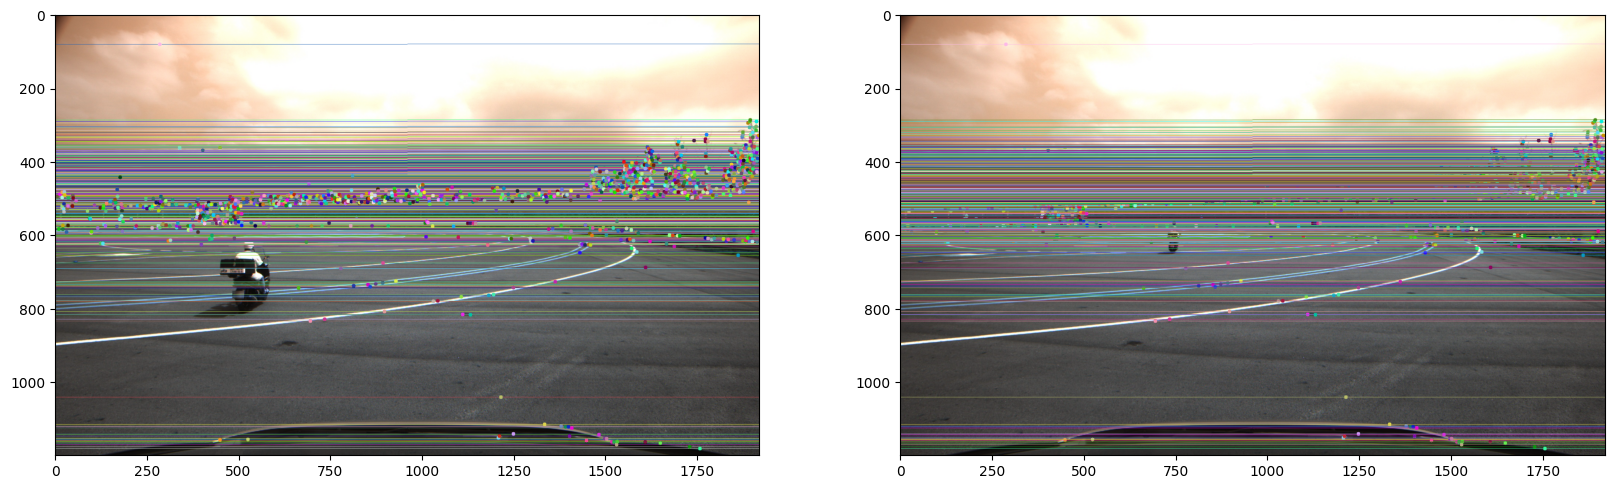

In [58]:
# Epiline을 찾아 그려준다.

# Find epilines corresponding to points in right image (second image) and
# drawing its lines on left image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1,1,2), 2,F)
lines1 = lines1.reshape(-1,3)
img5,img6 = drawlines(img1,img2,lines1,pts1,pts2)
# Find epilines corresponding to points in left image (first image) and
# drawing its lines on right image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1,1,2), 1,F)
lines2 = lines2.reshape(-1,3)
img3,img4 = drawlines(img2, img1, lines2, pts2, pts1)

plt.figure(figsize=(20, 15))
plt.subplot(121),plt.imshow(img5)
plt.subplot(122),plt.imshow(img3)
plt.show()

In [75]:
np.around(F, 3)xx

array([[ 0.   , -0.   , -0.002],
       [ 0.   , -0.   , -0.007],
       [ 0.002,  0.007,  0.   ]])

# # Essential Matrix
---

In [83]:
E, mask = cv2.findEssentialMat(points1=pts1, 
                               points2=pts2, 
                               cameraMatrix=intrinsic[:3, :3],
                               method = cv2.RANSAC,
                               prob = 0.999,
                               threshold = 1.0)

E

array([[-1.45486425e-17, -4.08248290e-01, -4.08248290e-01],
       [ 4.08248290e-01, -1.41527001e-17, -4.08248290e-01],
       [ 4.08248290e-01,  4.08248290e-01, -7.00457613e-19]])

In [90]:
np.around(np.matmul(E, F), 4)

array([[-0.0007, -0.0028,  0.0028],
       [-0.0007, -0.0028, -0.0007],
       [ 0.    , -0.    , -0.0035]])

In [117]:
_, r, t, _ = cv2.recoverPose(E, pts1, pts2, intrinsic[:3, :3])

In [115]:
print(np.around(E, 4))

[[-0.     -0.4082 -0.4082]
 [ 0.4082 -0.     -0.4082]
 [ 0.4082  0.4082 -0.    ]]


In [113]:
F

array([[ 7.59099247e-24, -3.79918295e-06, -1.79885711e-03],
       [ 3.79918295e-06, -7.79566400e-23, -6.85068496e-03],
       [ 1.79885711e-03,  6.85068496e-03,  0.00000000e+00]])

In [121]:
E

array([[-1.45486425e-17, -4.08248290e-01, -4.08248290e-01],
       [ 4.08248290e-01, -1.41527001e-17, -4.08248290e-01],
       [ 4.08248290e-01,  4.08248290e-01, -7.00457613e-19]])

In [124]:
rotation_matrix

array([[ 9.99153943e-01, -2.14515212e-04, -4.11260435e-02],
       [ 3.14733503e-04, -9.99917231e-01,  1.28620366e-02],
       [-4.11253986e-02, -1.28640983e-02, -9.99071177e-01]])

# # 특수환경 자율주행 3D 이미지
---

## # make dataframe
---

In [ ]:
# 검색용 코드
df.loc[df['xyzlwh'].apply(lambda x: -31.16 in x[:3])]

### # training
---

In [ ]:
train_df = pd.DataFrame(columns=['clip', 'frame', 'xyxy', 'xyzlwh', 'theta', 'eulerangle', 'translation', 'fxfycxcy', 'k1k2p1p2', 'pcd', 'class'])
idx = 0

path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/training/'
clips = sorted([i for i in os.listdir(path) if 'drive_' in i])
# clip = clips[20]

for clip in clips:
    try:
        with open(path+clip+'/calib.txt', 'r') as f:
            calib = [re.sub('\n', '', i) for i in f.readlines()]

        eulerangle = calib[4].split(',')
        translation = calib[6].split(',')
        intrinsic = calib[8].split(',')
        fxfycxcy = intrinsic[:4]
        k1k2p1p2 = intrinsic[4:]

        metas = sorted(os.listdir(path+clip+'/meta/'))

        for meta in metas:
            meta = path+clip+f'/meta/{meta}'
            frame = meta[-11:-5]

            pcd_f = o3d.t.io.read_point_cloud(path+clip+f'/lidar/{clip}_{frame}.pcd')
            positions = pcd_f.point.positions.numpy()
            intensity = pcd_f.point.intensity.numpy()
            pcd = np.concatenate((positions, intensity), axis = 1)

            with open(meta, 'r') as f:
                meta_js = json.load(f)

            objects = meta_js['OBJECT_LIST'][0]['3D_LIST']
            for i in range(len(objects)):
                object = objects[i]
                xyxy = object['BOX']
                xyz = object['LOCATION']
                hwl = object['DIMENSION']
                xyzlwh = xyz + hwl[2:3] + hwl[1:2] + hwl[0:1]
                # xyzlwh = ', '.join(map(str, xyzlwh))
                theta = object['YAW']
                class_ = object['TYPE']

                train_df.loc[idx] = [clip, frame, xyxy, xyzlwh, theta, eulerangle, translation, fxfycxcy, k1k2p1p2, pcd, class_]

                idx+=1
    except:
        pass
    
    train_df.to_csv('/data/NIA50/data/특수환경 자율주행 3D 이미지/train_df.csv', index=False)

### # validation
---

In [ ]:
val_df = pd.DataFrame(columns=['clip', 'frame', 'xyxy', 'xyzlwh', 'theta', 'eulerangle', 'translation', 'fxfycxcy', 'k1k2p1p2', 'class', 'type'])
idx = 0

path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/'
clips = sorted([i for i in os.listdir(path) if 'drive_' in i])
# clip = clips[20]

for clip in clips:
    try:
        with open(path+clip+'/calib.txt', 'r') as f:
            calib = [re.sub('\n', '', i) for i in f.readlines()]

        eulerangle = list(map(float, calib[4].split(',')))
        translation = list(map(float, calib[6].split(',')))
        intrinsic = list(map(float, calib[8].split(',')))
        fxfycxcy = intrinsic[:4]
        k1k2p1p2 = intrinsic[4:]

        metas = sorted(os.listdir(path+clip+'/lidar/'))

        for meta in metas:
            meta = path+clip+f'/meta/{meta}'
            frame = meta[-11:-5]

            # pcd_f = o3d.t.io.read_point_cloud(path+clip+f'/lidar/{clip}_{frame}.pcd')
            # positions = pcd_f.point.positions.numpy()
            # intensity = pcd_f.point.intensity.numpy()
            # pcd = np.concatenate((positions, intensity), axis = 1).tobytes()

            with open(meta, 'r') as f:
                meta_js = json.load(f)

            objects = meta_js['OBJECT_LIST'][0]['3D_LIST']
            for i in range(len(objects)):
                object = objects[i]
                xyxy = object['BOX']
                xyz = object['LOCATION']
                hwl = object['DIMENSION']
                xyzlwh = xyz + hwl[2:3] + hwl[1:2] + hwl[0:1]
                # xyzlwh = ', '.join(map(str, xyzlwh))
                theta = object['YAW']
                class_ = object['CLASS']
                type_ = object['TYPE']

                val_df.loc[idx] = [clip, frame, xyxy, xyzlwh, theta, eulerangle, translation, fxfycxcy, k1k2p1p2, class_, type_]

                idx+=1
    except:
        pass
    
    val_df.to_csv('/data/NIA50/data/특수환경 자율주행 3D 이미지/val_df.csv', index=False)

## # PV-RCNN (fit custom dataset)
---

### # save npy
---

In [15]:
val_df = pd.read_csv('/data/NIA50/data/특수환경 자율주행 3D 이미지/val_df.csv')
val_df['frame'] = val_df['frame'].apply(lambda x: str(x).zfill(6))
val_df.head()

,clip,frame,xyxy,xyzlwh,theta,eulerangle,translation,fxfycxcy,k1k2p1p2,class,type
0,drive_1151,000000,"[1113, 576, 1126, 611]","[0.0, 0.0, 0.0, 0, 0, 0]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",BICYCLE,AUTO_BICYCLE
1,drive_1151,000001,"[1112, 573, 1125, 608]","[0.0, 0.0, 0.0, 0, 0, 0]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",BICYCLE,AUTO_BICYCLE
2,drive_1151,000002,"[1112, 573, 1125, 608]","[0.0, 0.0, 0.0, 0, 0, 0]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",BICYCLE,AUTO_BICYCLE
3,drive_1151,000003,"[1112, 573, 1125, 608]","[0.0, 0.0, 0.0, 0, 0, 0]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",BICYCLE,AUTO_BICYCLE
4,drive_1151,000004,"[1111, 574, 1124, 609]","[0.0, 0.0, 0.0, 0, 0, 0]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",BICYCLE,AUTO_BICYCLE


In [ ]:
path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/'
save_path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/points'

true_data = val_df.loc[val_df['xyzlwh']!='[0.0, 0.0, 0.0, 0, 0, 0]']
clips = true_data['clip'].unique()

for clip in clips:
    frames = true_data.loc[true_data['clip'] == clip, 'frame'].unique()

    for frame in frames:
        try:
            pcd_name = pcd_name = clip + f'_{frame}.pcd'
            pcd_f = o3d.t.io.read_point_cloud(path+clip+'/lidar/'+pcd_name)

            positions = pcd_f.point.positions.numpy()
            intensity = pcd_f.point.intensity.numpy()
            pcd = np.concatenate((positions, intensity), axis = 1)

            npy = np.save(save_path+f'/{clip}_{frame}.npy', pcd)
        except:
            pass

In [ ]:
path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/ImageSets'

### # dividing train, val
---

#### # imagesets
---

In [ ]:
val_df = pd.read_csv('/data/NIA50/data/특수환경 자율주행 3D 이미지/val_df.csv')
val_df['frame'] = val_df['frame'].apply(lambda x: str(x).zfill(6))
tdf = val_df.loc[val_df['xyzlwh']!='[0.0, 0.0, 0.0, 0, 0, 0]']
tdf.head()

In [ ]:
images = []

clips = tdf['clip'].unique()
for clip in clips:

    frames = tdf.loc[tdf['clip'] == clip, 'frame'].unique()
    for frame in frames:
        image = clip+f'_{frame}'
        images.append(image)

len(images), len(os.listdir('/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/points'))

In [11]:
images = sorted([re.sub('.npy', '', i) for i in os.listdir('/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/points')])
len(images)

20269

In [ ]:
path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/ImageSets/'

train, val = train_test_split(images, test_size=0.2, random_state=0)

with open(path+'train.txt', 'w') as f:
    f.write('\n'.join(sorted(train)))

with open(path+'val.txt', 'w') as f:
    f.write('\n'.join(sorted(val)))

#### # labels
---

In [ ]:
# 차집합

set(labels) - set(images)
set(labels).difference(set(images))

In [ ]:
path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/labels/'
labels = [re.sub('.txt', '', i) for i in os.listdir(path)]

for n_pcd in set(labels) - set(images):
    if os.path.exists(path+f'{n_pcd}.txt'):
        os.remove(path+f'{n_pcd}.txt')

#### # calibration
---

In [ ]:
from scipy.spatial.transform import Rotation as R


path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/calib/'

clips = tdf['clip'].unique()
for clip in clips:

    frames = tdf.loc[tdf['clip'] == clip, 'frame'].unique()
    for frame in frames:
        image = clip+f'_{frame}'

        fxfycxcy = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'fxfycxcy'].values[0])
        eulerangle = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'eulerangle'].values[0])
        translation = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'translation'].values[0])
        intrinsic = np.asarray([[fxfycxcy[0], 0, fxfycxcy[2]], [0, fxfycxcy[1], fxfycxcy[3]], [0, 0, 1]])
        rotation_matrix = R.from_euler('xyz', eulerangle, degrees=True).as_matrix()

        p0 = np.hstack([intrinsic, np.zeros((3, 1))])
        R0_rect = np.eye(3)
        Tr_velo_to_cam = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])
        Tr_imu_to_velo = np.zeros((12))

        # to string
        p0 = ' '.join(map(str, p0.reshape(-1).tolist()))
        p1 = p0
        p2 = p0
        p3 = p0
        R0_rect = ' '.join(map(str, R0_rect.reshape(-1).tolist()))
        Tr_velo_to_cam = ' '.join(map(str, Tr_velo_to_cam.reshape(-1).tolist()))
        Tr_imu_to_velo = ' '.join(map(str, Tr_imu_to_velo.reshape(-1).tolist()))

        label_lines = ['P0: '+p0, 'P1: '+p1, 'P2: '+p2, 'P3: '+p3, 'R0_rect: '+R0_rect, 'Tr_velo_to_cam: '+Tr_velo_to_cam, 'Tr_imu_to_velo: '+Tr_imu_to_velo]
        with open(path + f'{image}.txt', 'w') as f:
            f.write('\n'.join(label_lines))

            # f.write(f'P0: {p0}\n')
            # f.write(f'P1: {p1}\n')
            # f.write(f'P2: {p2}\n')
            # f.write(f'P3: {p3}\n')
            # f.write(f'R0_rect: {R0_rect}\n')
            # f.write(f'Tr_velo_to_cam: {Tr_velo_to_cam}\n')
            # f.write(f'Tr_imu_to_velo: {Tr_imu_to_velo}')

In [ ]:
path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/calib/'
labels = [re.sub('.txt', '', i) for i in os.listdir(path)]

for n_pcd in set(labels) - set(images):
    if os.path.exists(path+f'{n_pcd}.txt'):
        os.remove(path+f'{n_pcd}.txt')

## # PointRCNN (fit kitti datset)
---

In [8]:
val_df = pd.read_csv('/data/NIA50/data/특수환경 자율주행 3D 이미지/val_df.csv')
val_df['frame'] = val_df['frame'].apply(lambda x: str(x).zfill(6))
images = []
for i in val_df.index.values:
    image = val_df.loc[i]['clip'] + '_' + val_df.loc[i]['frame']
    images.append(image)
val_df['image'] = images
tdf = val_df.loc[val_df['xyzlwh']!='[0.0, 0.0, 0.0, 0, 0, 0]']
tdf.head(3)

,clip,frame,xyxy,xyzlwh,theta,eulerangle,translation,fxfycxcy,k1k2p1p2,class,type,image
19,drive_1151,000019,"[-5, 631, 231, 830]","[-5.18, -6.52, -1.04, 4.44, 1.76, 1.81]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",VEHICLE,SEDAN,drive_1151_000019
20,drive_1151,000020,"[0, 614, 280, 837]","[-5.73, -6.67, -1.03, 4.44, 1.75, 1.8]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",VEHICLE,SEDAN,drive_1151_000020
21,drive_1151,000021,"[-8, 604, 314, 845]","[-6.36, -6.66, -1.02, 4.44, 1.75, 1.79]",0.0,"[-6.308843, -0.01, 0.0]","[0.02, -0.02, -0.03]","[1067.249617, 1070.402406, 967.123811, 600.618...","[-0.156654, 0.10625, 0.0, 0.0]",VEHICLE,SEDAN,drive_1151_000021


### # imagesets
---

In [9]:
# 라벨 복사

import glob
import shutil

exi_pcd = glob.glob('/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/*/lidar/*.pcd')
exi_pcd = [i[-21:-4] for i in exi_pcd]

images_true = []
for clip in tdf['clip'].unique():
    for frame in tdf.loc[tdf['clip'] == clip, 'frame'].unique():
        image = clip + f'_{frame}'
        images_true.append(image)
        
images = sorted(set(images_true) & set(exi_pcd))
# images = sorted([re.sub('.npy', '', i) for i in os.listdir('/data/NIA50/data/특수환경 자율주행 3D 이미지/mm_Train3D/points')])

images_re, test = train_test_split(images, test_size = 0.1, random_state = 0)
train, val = train_test_split(images_re, test_size = 0.2, random_state = 0)

path = '/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/imagesets/'

# with open(path+'train.txt', 'w') as f:
#     f.write('\n'.join(sorted(train)))

# with open(path+'val.txt', 'w') as f:
#     f.write('\n'.join(sorted(val)))
    
# with open(path+'test.txt', 'w') as f:
#     f.write('\n'.join(sorted(test)))

In [10]:
len(train), len(val), len(test)

(14593, 3649, 2027)

### # velodyne
---

In [106]:
pcd_files = glob.glob('/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/*/lidar/*.pcd')

pcd_path = []
for pcd_file in pcd_files:
    for image in images:
        if image == pcd_file[-21:-4]:
            pcd_path.append(pcd_file)

In [154]:
os.makedirs('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/velodyne', exist_ok=True)
os.makedirs('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/testing/velodyne', exist_ok=True)

for pcd_file in pcd_path:
    pcd_f = o3d.t.io.read_point_cloud(pcd_file)
    positions = pcd_f.point.positions.numpy()
    intensity = pcd_f.point.intensity.numpy()
    
    pcd = np.concatenate((positions, intensity), axis = 1)
    pcd_bytes = pcd.tobytes()
    
    if pcd_file[-21:-4] in train:
        with open(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/velodyne/{pcd_file[-21:-4]}.bin', 'wb') as f:
            f.write(pcd_bytes)
            
    elif pcd_file[-21:-4] in val:
        with open(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/velodyne/{pcd_file[-21:-4]}.bin', 'wb') as f:
            f.write(pcd_bytes)

    elif pcd_file[-21:-4] in test:
        with open(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/testing/velodyne/{pcd_file[-21:-4]}.bin', 'wb') as f:
            f.write(pcd_bytes)

### # calib
---

In [197]:
np.asarray([[0, 1, 0],
            [0, 0, 1],
            [1, 0, 0]])

array([[0, 1, 0],
       [0, 0, 1],
       [1, 0, 0]])

In [211]:
from scipy.spatial.transform import Rotation as R


clips = tdf['clip'].unique()
for clip in clips[:1]:

    frames = tdf.loc[tdf['clip'] == clip, 'frame'].unique()
    for frame in frames:
        image = clip+f'_{frame}'

        fxfycxcy = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'fxfycxcy'].values[0])
        # eulerangle = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'eulerangle'].values[0]) * np.asarray(180/np.pi)
        eulerangle = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'eulerangle'].values[0])
        translation = json.loads(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'translation'].values[0])
        intrinsic = np.asarray([[fxfycxcy[0], 0, fxfycxcy[2]], [0, fxfycxcy[1], fxfycxcy[3]], [0, 0, 1]])
        rotation_matrix = R.from_euler('xyz', eulerangle, degrees=True).as_matrix()

        p0 = np.hstack([intrinsic, np.zeros((3, 1))])
        R0_rect = np.eye(3)
        # velo_to_cam_rotation = np.asarray([[0, 1, 0],
        #                                    [0, 0, 1],
        #                                    [1, 0, 0]])
        Tr_velo_to_cam = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])
        Tr_imu_to_velo = np.zeros((12))

        # to string
        p0 = ' '.join(map(str, p0.reshape(-1).tolist()))
        p1 = p0
        p2 = p0
        p3 = p0
        R0_rect = ' '.join(map(str, R0_rect.reshape(-1).tolist()))
        # R0_rect = ' '.join(map(str, rotation_matrix.reshape(-1).tolist()))
        Tr_velo_to_cam = ' '.join(map(str, Tr_velo_to_cam.reshape(-1).tolist()))
        Tr_imu_to_velo = ' '.join(map(str, Tr_imu_to_velo.reshape(-1).tolist()))

        label_lines = ['P0: '+p0, 'P1: '+p1, 'P2: '+p2, 'P3: '+p3, 'R0_rect: '+R0_rect, 'Tr_velo_to_cam: '+Tr_velo_to_cam, 'Tr_imu_to_velo: '+Tr_imu_to_velo]
                
        # if image in train:
        #     with open('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/calib/' + f'{image}.txt', 'w') as f:
        #         f.write('\n'.join(label_lines))
                
        if image in sorted(val)[:1]:
            with open('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/calib/' + f'{image}.txt', 'w') as f:
                f.write('\n'.join(label_lines))
                
        # elif image in test:
        #     with open('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/testing/calib/' + f'{image}.txt', 'w') as f:
        #         f.write('\n'.join(label_lines))
                
            # f.write(f'P0: {p0}\n')
            # f.write(f'P1: {p1}\n')
            # f.write(f'P2: {p2}\n')
            # f.write(f'P3: {p3}\n')
            # f.write(f'R0_rect: {R0_rect}\n')
            # f.write(f'Tr_velo_to_cam: {Tr_velo_to_cam}\n')
            # f.write(f'Tr_imu_to_velo: {Tr_imu_to_velo}')

### # label_2
---

In [11]:
# alpha 구하는 공식

import math

def normalizeAngle(angle):
    result = angle % (2*math.pi)
    if result < -math.pi:
        result += 2*math.pi
    elif result > math.pi:
        result -= 2*math.pi
    return result

def cal_alpha_ori(x, z, ry):  
    angle = ry
    angle -= -math.atan2(z, x) -1.5*math.pi 
    alpha = normalizeAngle(angle)
    return alpha # -1.818032754845337

cal_alpha_ori(2.5702, 9.7190, -1.5595)

-1.818032754845337

In [207]:
os.makedirs('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/label_2', exist_ok=True)

idx = tdf.index.values

for i in idx[:1]:
    clip = tdf.loc[i]['clip']
    frame = tdf.loc[i]['frame']
    image = clip + f'_{frame}'
    
    type_ = tdf.loc[i]['class']
    truncation = 0.00
    occulsion = 0
    xyxy = json.loads(tdf.loc[i]['xyxy'])
    xyzlwh = json.loads(tdf.loc[i]['xyzlwh'])
    hwlxyz = [xyzlwh[5], xyzlwh[4], xyzlwh[3], xyzlwh[0], xyzlwh[1], xyzlwh[2]]
    rotation_y = tdf.loc[i]['theta'] # rotation_y = theta
    alpha = np.around(cal_alpha_ori(xyzlwh[0]*-1, xyzlwh[2], rotation_y), 2)
    
    if type_ == 'VEHICLE': type_ = 'Car'
    elif type_ == 'BICYCLE': type_ = 'Cyclist'
    elif type_ == 'PEDESTRIAN': type_ = 'Pedestrian'
    
    if xyxy[0] < 0: xyxy[0] = 0
    if xyxy[1] < 0: xyxy[1] = 0
    if xyxy[2] > 1920: xyxy[2] = 1920
    if xyxy[3] > 1200: xyxy[3] = 1200
    
    xyxy = ' '.join(map(str, xyxy))
    hwlxyz = ' '.join(map(str, hwlxyz))
    
    label = list(map(str, [type_, truncation, occulsion, alpha, xyxy, hwlxyz, rotation_y]))
    
    if image in train + val:
        with open(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/label_2/{image}.txt', 'w') as f:
            f.write(' '.join(label))
            f.write('\n')

In [242]:
# clips = tdf['clip'].unique()
# for clip in clips[:1]:
    
#     frames = tdf.loc[tdf['clip']==clip, 'frame'].unique()
#     for frame in frames:
        
#         image = clip+f'_{frame}'
#         for idx in len(tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame))
#         class_ = tdf.loc[(tdf['clip']==clip) & (tdf['frame']==frame), 'class']

### # image_2
---

In [ ]:
os.makedirs('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/image_2', exist_ok=True)
os.makedirs('/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/testing/image_2', exist_ok=True)

for train_img in train + val:
    copy_path = glob.glob(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/*/image_0/{train_img}.jpg')[0]
    paste_path = f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/training/image_2/{train_img}.jpg'
    shutil.copy(copy_path, paste_path)
    
# for test_img in test:
#     copy_path = glob.glob(f'/data/NIA50/data/특수환경 자율주행 3D 이미지/Validation/*/image_0/{test_img}.jpg')[0]
#     paste_path = f'/data/NIA50/data/특수환경 자율주행 3D 이미지/pointrcnn_Train3D/testing/image_2/{test_img}.jpg'
#     shutil.copy(copy_path, paste_path)

# # NIA48
---
- PointRCNN

In [85]:
def get_cropped_and_resized_intrinsic(
    fx, fy, cx, cy, crop_cx, crop_cy, resize_fx, resize_fy):
    '''
    crop_cx : crop size of u axis orientation in image plane
    crop_cy : crop size of v axis orientation in image plane
    resize_fx : resize ratio of width orientation in image plane
    resize_fy : resize ratio of height orientation in image plane    
    '''

    cx -= crop_cx
    cy -= crop_cy

    fx *= resize_fx
    fy *= resize_fy

    cx *= resize_fx
    cy *= resize_fy

    return fx, fy, cx, cy

In [86]:
fpd

[1044.406012,
 1045.640421,
 977.767781,
 603.58031,
 -0.120864,
 0.057409,
 0.000536,
 -0.000143]

In [ ]:
735, 575

In [87]:
1200/575

2.0869565217391304

In [88]:
resize_fpd = get_cropped_and_resized_intrinsic(fpd[0], fpd[1], fpd[2], fpd[3], 0, 0, 1920/735, 1200/575)

(2728.2442762448977, 2182.206096, 2554.1688973061223, 1259.645864347826)

In [84]:
1920 / 735

2.6122448979591835

In [2]:
# 문자열 숫자리스트로 바꾸는 함수
def str_cng(txt):
    txt = txt.replace('\n', '').split(',')
    txt = list(map(float, txt))
    
    return txt

## # calib
---

In [89]:

path = '/data/NIA50/50-2/data/NIA48/training/calib/'
os.makedirs(path, exist_ok=True)

with open('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/calib/Lidar_camera_calib/2-048_02244_LCC_CF.txt') as f:
    camera_calib = f.readlines()
# with open('/data/NIA48/S_Clip_03400_06/calib/Lidar_radar_calib/2-048_03400_LRC_RF.txt') as f:
#     radar_calib = f.readlines()

essential_matrix = np.asarray([[0, 1, 0],
                               [0, 0, 1],
                               [1, 0, 0]])
# essential_matrix = E
eulerangle = str2list(camera_calib[4]) # z, x, y
# eulerangle = np.asarray(eulerangle) + np.asarray([-360*np.pi/180, -90*np.pi/180, -90*np.pi/180])
X = R.from_euler('X', eulerangle[1]).as_matrix()
Y = R.from_euler('Y', eulerangle[0]).as_matrix()
Z = R.from_euler('Z', eulerangle[2]).as_matrix()
rotation_matrix = Z @ Y @ X
# rotation_matrix = R.from_euler('xyz', eulerangle).as_matrix()
# e_rotation_matrix = np.matmul(rotation_matrix, essential_matrix)
translation = np.asarray(str2list(camera_calib[6]))
fpd = str2list(camera_calib[8])
# resize_fpd = get_cropped_and_resized_intrinsic(fpd[0], fpd[1], fpd[2], fpd[3], 0, 0, 1920/735, 1200/575)
# fpd = resize_fpd
intrinsic = np.asarray([fpd[0], 0, fpd[2], 0,
                        0, fpd[1], fpd[3], 0,
                        0, 0, 1, 0]).reshape(3,4)
distcoeffs = str2list(camera_calib[8])[4:]
# new_intrinsic, _ = cv2.getOptimalNewCameraMatrix(cameraMatrix=intrinsic[:3, :3],
#                                                 distCoeffs=np.asarray(distcoeffs),
#                                                 imageSize=(1200, 1920),
#                                                 alpha=1)
# intrinsic = np.hstack([new_intrinsic, np.asarray([0, 0, 0]).reshape(3, 1)])
extrinsic = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])
# extrinsic = np.hstack([e_rotation_matrix, np.asarray(translation).reshape(3, -1)])

# projection_matrix = intrinsic
# projection_matrix = np.matmul(intrinsic, extrinsic)
# projection_matrix[2, 2] = 1
# projection_matrix[:, 3] = 0

# p2 = [projection_matrix[0, 0], 0, projection_matrix[0, 2], 0,
#       0, projection_matrix[1, 1], projection_matrix[1, 2], 0,
#       0, 0, 1, 0]
# p2 = projection_matrix.reshape(-1).tolist()
p2 = intrinsic.reshape(-1).tolist()

R0_rect = np.eye(3).reshape(-1).tolist()
# R0_rect = rotation_matrix.reshape(-1).tolist()
Tr_velo_to_cam = extrinsic.reshape(-1).tolist()
# Tr_velo_to_cam = np.zeros((12)).tolist()
Tr_imu_to_velo = np.zeros((12)).tolist()

calib_kitti =  ['P0: '+list2str(p2), 
                'P1: '+list2str(p2), 
                'P2: '+list2str(p2), 
                'P3: '+list2str(p2), 
                'R0_rect: '+list2str(R0_rect), 
                'Tr_velo_to_cam: '+list2str(Tr_velo_to_cam), 
                'Tr_imu_to_velo: '+list2str(Tr_imu_to_velo)]

with open(path + 'test48.txt', 'w') as f:
    f.write('\n'.join(calib_kitti))

# print(essential_matrix, '\n')
# print(rotation_matrix, '\n')
# print(extrinsic, '\n')

# with open('/data/hwang/datasets/kitti/training/calib/000038.txt') as f:
#     calib = f.readlines()
#     extrinsic_ = list(map(float, calib[5].replace('\n', '').split(' ')[1:]))
#     extrinsic_ = np.asarray(extrinsic_).reshape(3, 4)    
#     R0_rect = list(map(float, calib[4].replace('\n', '').split(' ')[1:]))
#     R0_rect = np.asarray(R0_rect).reshape(3, 3)

# print(extrinsic_)

## # label_2
---

In [114]:
path = '/data/NIA50/50-2/data/NIA48/training/label_2/'
os.makedirs(path, exist_ok=True)


with open('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/result/2-048_02244_FC_001.json', 'r') as f:
    meta = json.load(f)
    
type_ = meta['annotation'][0]['category']
truncation = 0.0
occulsion = 0
xyxy = meta['annotation'][0]['3d_box'][0]['2d_box']
xyz = meta['annotation'][0]['3d_box'][0]['location']
rotation_y = abs(meta['annotation'][0]['3d_box'][0]['rotation_y']) - 90 * np.pi/180

xyz_re = np.matmul(extrinsic, np.asarray(xyz + [1]).reshape(4, 1)).reshape(-1).tolist()
# xyz = np.matmul(e_rotation_matrix, np.asarray(xyz).reshape(3, 1)).reshape(-1).tolist()
whl = meta['annotation'][0]['3d_box'][0]['dimension']
hwlxyz = [whl[1], whl[0], whl[2]] + xyz_re

alpha = cal_alpha_ori(xyz_re[0], xyz_re[2], rotation_y)

xyxy = ' '.join(map(str, xyxy))
hwlxyz = ' '.join(map(str, hwlxyz))

label = list(map(str, [type_, truncation, occulsion, alpha, xyxy, hwlxyz, rotation_y]))

with open(path+'test48.txt', 'w') as f:
    f.write(' '.join(label))

In [176]:
num = '02244'

path = '/data/NIA50/50-2/data/NIA48/training/calib/'
os.makedirs(path, exist_ok=True)

with open(f'/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_{num}_02/calib/Lidar_camera_calib/2-048_{num}_LCC_CF.txt') as f:
    camera_calib = f.readlines()
    
eulerangle = str2list(camera_calib[4])
eulerangle = np.asarray(eulerangle) + np.asarray([90*np.pi/180, -90*np.pi/180, -180*np.pi/180])
eulerangle = np.asarray(eulerangle) + np.asarray([0*np.pi/180, 0*np.pi/180, 90*np.pi/180])
# eulerangle[2] = eulerangle[2]*-1

X = R.from_euler('X', eulerangle[1]).as_matrix()
Y = R.from_euler('Y', eulerangle[0]).as_matrix()
Z = R.from_euler('Z', eulerangle[2]).as_matrix()
rotation_matrix = Z @ Y @ X

# e_rotation_matrix = np.matmul(essential_matrix, rotation_matrix)
# e_rotation_matrix = np.matmul(rotation_matrix, essential_matrix)
translation = np.asarray(str2list(camera_calib[6]))
# translation = translation = np.asarray(str2list(camera_calib[6])) + np.asarray([0, 0.6, 0.2])
fpd = str2list(camera_calib[8])
# resize_fpd = get_cropped_and_resized_intrinsic(fpd[0], fpd[1], fpd[2], fpd[3], 0, 0, 1920/745, 1200/575)
# fpd = resize_fpd
intrinsic = np.asarray([fpd[0], 0, fpd[2], 0,
                        0, fpd[1], fpd[3], 0,
                        0, 0, 1, 0]).reshape(3,4)
# distortion = str2list(camera_calib[8])[4:]
# new_intrinsic, _ = cv2.getOptimalNewCameraMatrix(cameraMatrix=intrinsic[:3, :3],
#                                                 distCoeffs=np.asarray(distortion),
#                                                 imageSize=(1200, 1920),
#                                                 alpha=1)
# intrinsic = np.hstack([new_intrinsic, np.asarray([0, 0, 0]).reshape(3, 1)])
extrinsic = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])

p2 = intrinsic.reshape(-1).tolist()

R0_rect = np.eye(3).reshape(-1).tolist()
# R0_rect = rotation_matrix.reshape(-1).tolist()
Tr_velo_to_cam = extrinsic.reshape(-1).tolist()
# Tr_velo_to_cam = np.zeros((12)).tolist()
Tr_imu_to_velo = np.zeros((12)).tolist()

calib_kitti =  ['P0: '+list2str(p2), 
                'P1: '+list2str(p2), 
                'P2: '+list2str(p2), 
                'P3: '+list2str(p2), 
                'R0_rect: '+list2str(R0_rect), 
                'Tr_velo_to_cam: '+list2str(Tr_velo_to_cam), 
                'Tr_imu_to_velo: '+list2str(Tr_imu_to_velo)]

with open(path + 'test48.txt', 'w') as f:
    f.write('\n'.join(calib_kitti))

path = '/data/NIA50/50-2/data/NIA48/training/label_2/'
os.makedirs(path, exist_ok=True)


with open(f'/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_{num}_02/result/2-048_{num}_FC_001.json', 'r') as f:
    meta = json.load(f)
    
type_ = meta['annotation'][0]['category']
truncation = 0.0
occulsion = 0
xyxy = meta['annotation'][0]['3d_box'][0]['2d_box']
xyz = meta['annotation'][0]['3d_box'][0]['location']
rotation_y = np.abs(meta['annotation'][0]['3d_box'][0]['rotation_y']) - 90 * np.pi/180 # radian
# rotation_y = meta['annotation'][0]['3d_box'][0]['rotation_y']


xyz_re = np.matmul(extrinsic, np.asarray(xyz + [1]).reshape(4, 1)).reshape(-1).tolist()
# xyz = np.matmul(e_rotation_matrix, np.asarray(xyz).reshape(3, 1)).reshape(-1).tolist()
whl = meta['annotation'][0]['3d_box'][0]['dimension']
hwlxyz = [whl[1], whl[0], whl[2]] + xyz_re
# hwlxyz = [whl[1], whl[0], whl[2]] + [xyz_re[2], xyz_re[1], xyz_re[0]]

alpha = cal_alpha_ori(xyz_re[0], xyz_re[2], rotation_y)

xyxy = ' '.join(map(str, xyxy))
hwlxyz = ' '.join(map(str, hwlxyz))

label = list(map(str, [type_, truncation, occulsion, alpha, xyxy, hwlxyz, rotation_y]))

with open(path+'test48.txt', 'w') as f:
    f.write(' '.join(label))

In [691]:
eulerangle = str2list(camera_calib[4])
# eulerangle = np.asarray(eulerangle) + np.asarray([-180*np.pi/180, 90*np.pi/180, -90*np.pi/180])
R.from_euler('XYZ', eulerangle).as_matrix().T

array([[ 9.99153943e-01, -8.44462983e-04,  4.11179322e-02],
       [-3.14733503e-04, -9.99916897e-01, -1.28879435e-02],
       [ 4.11253986e-02,  1.28640983e-02, -9.99071177e-01]])

In [690]:
eulerangle = str2list(camera_calib[4])
# eulerangle = np.asarray(eulerangle) + np.asarray([-180*np.pi/180, 90*np.pi/180, -90*np.pi/180])
R.from_euler('xyz', eulerangle).as_matrix()

array([[ 9.99153943e-01, -2.14515212e-04, -4.11260435e-02],
       [ 3.14733503e-04, -9.99917231e-01,  1.28620366e-02],
       [-4.11253986e-02, -1.28640983e-02, -9.99071177e-01]])

In [663]:
np.asarray(Tr_velo, dtype=float).reshape(-1, 4)

array([[ 0.00692796, -0.9999722 , -0.00275783, -0.02457729],
       [-0.00116298,  0.00274984, -0.9999955 , -0.06127237],
       [ 0.9999753 ,  0.00693114, -0.0011439 , -0.3321029 ]])

In [144]:

path = '/data/NIA50/50-2/data/NIA48/training/calib/'
os.makedirs(path, exist_ok=True)

with open('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/calib/Lidar_camera_calib/2-048_02244_LCC_CF.txt') as f:
    camera_calib = f.readlines()
# with open('/data/NIA48/S_Clip_03400_06/calib/Lidar_radar_calib/2-048_03400_LRC_RF.txt') as f:
#     radar_calib = f.readlines()

# essential_matrix = np.asarray([[0, 1, 0],
#                                [0, 0, 1],
#                                [1, 0, 0]])
# essential_matrix = E
eulerangle = str2list(camera_calib[4])
eulerangle = np.asarray(eulerangle) + np.asarray([360*np.pi/180, 90*np.pi/180, 90*np.pi/180])
rotation_matrix = R.from_euler('xyz', eulerangle).as_matrix()
# e_rotation_matrix = np.matmul(essential_matrix, rotation_matrix)
# e_rotation_matrix = np.matmul(rotation_matrix, essential_matrix)
translation = np.asarray(str2list(camera_calib[6]))
fpd = str2list(camera_calib[8])
intrinsic = np.asarray([fpd[0], 0, fpd[2], 0,
                        0, fpd[1], fpd[3], 0,
                        0, 0, 1, 0]).reshape(3,4)
distortion = str2list(camera_calib[8])[4:]
new_intrinsic, _ = cv2.getOptimalNewCameraMatrix(cameraMatrix=intrinsic[:3, :3],
                                                distCoeffs=np.asarray(distortion),
                                                imageSize=(1200, 1920),
                                                alpha=0)
intrinsic = np.hstack([new_intrinsic, np.asarray([0, 0, 0]).reshape(3, 1)])
extrinsic = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])
# extrinsic = np.hstack([e_rotation_matrix, np.asarray(translation).reshape(3, -1)])

# projection_matrix = intrinsic
# projection_matrix = np.matmul(intrinsic, extrinsic)
# projection_matrix[2, 2] = 1
# projection_matrix[:, 3] = 0

# p2 = [projection_matrix[0, 0], 0, projection_matrix[0, 2], 0,
#       0, projection_matrix[1, 1], projection_matrix[1, 2], 0,
#       0, 0, 1, 0]
# p2 = projection_matrix.reshape(-1).tolist()
p2 = intrinsic.reshape(-1).tolist()

R0_rect = np.eye(3).reshape(-1).tolist()
# R0_rect = rotation_matrix.reshape(-1).tolist()
Tr_velo_to_cam = extrinsic.reshape(-1).tolist()
# Tr_velo_to_cam = np.zeros((12)).tolist()
Tr_imu_to_velo = np.zeros((12)).tolist()

calib_kitti =  ['P0: '+list2str(p2), 
                'P1: '+list2str(p2), 
                'P2: '+list2str(p2), 
                'P3: '+list2str(p2), 
                'R0_rect: '+list2str(R0_rect), 
                'Tr_velo_to_cam: '+list2str(Tr_velo_to_cam), 
                'Tr_imu_to_velo: '+list2str(Tr_imu_to_velo)]

with open(path + 'test48.txt', 'w') as f:
    f.write('\n'.join(calib_kitti))

# print(essential_matrix, '\n')
# print(rotation_matrix, '\n')
# print(extrinsic, '\n')

# with open('/data/hwang/datasets/kitti/training/calib/000038.txt') as f:
#     calib = f.readlines()
#     extrinsic_ = list(map(float, calib[5].replace('\n', '').split(' ')[1:]))
#     extrinsic_ = np.asarray(extrinsic_).reshape(3, 4)    
#     R0_rect = list(map(float, calib[4].replace('\n', '').split(' ')[1:]))
#     R0_rect = np.asarray(R0_rect).reshape(3, 3)

# print(extrinsic_)

path = '/data/NIA50/50-2/data/NIA48/training/label_2/'
os.makedirs(path, exist_ok=True)


with open('/data/NIA50/50-2/data/NIA48/fine_data/S_Clip_02244_02/result/2-048_02244_FC_001.json', 'r') as f:
    meta = json.load(f)
    
type_ = meta['annotation'][0]['category']
truncation = 0.0
occulsion = 0
xyxy = meta['annotation'][0]['3d_box'][0]['2d_box']
xyz = meta['annotation'][0]['3d_box'][0]['location']
rotation_y = abs(meta['annotation'][0]['3d_box'][0]['rotation_y']) - 90 * np.pi/180

xyz_re = np.matmul(extrinsic, np.asarray(xyz + [1]).reshape(4, 1)).reshape(-1).tolist()
# xyz = np.matmul(e_rotation_matrix, np.asarray(xyz).reshape(3, 1)).reshape(-1).tolist()
whl = meta['annotation'][0]['3d_box'][0]['dimension']
hwlxyz = [whl[1], whl[0], whl[2]] + xyz_re

alpha = cal_alpha_ori(xyz_re[0], xyz_re[2], rotation_y)

xyxy = ' '.join(map(str, xyxy))
hwlxyz = ' '.join(map(str, hwlxyz))

label = list(map(str, [type_, truncation, occulsion, alpha, xyxy, hwlxyz, rotation_y]))

with open(path+'test48.txt', 'w') as f:
    f.write(' '.join(label))

# # NIA50
---

## # velodyne
---

In [495]:
os.makedirs('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/velodyne', exist_ok=True)

path = '/data/NIA50/50-2/data/NIA50_samples/'
clips = sorted(os.listdir(path))
for clip in clips[1:2]:
    # frames = sorted(os.listdir(f'/data/NIA50/50-2/data/NIA50_samples/{clip}/lidar'))    
    pcd_files = sorted(glob.glob(path+f'{clip}/lidar/*.pcd'))
    for pcd_file in pcd_files:
        frame = pcd_file[-8:-4]
        pcd = o3d.t.io.read_point_cloud(pcd_file)
        positions = pcd.point.positions.numpy()
        intensity = pcd.point.intensity.numpy()
        
        pcd = np.concatenate((positions, intensity), axis = 1)
        pcd_bytes = pcd.tobytes()
        
        with open(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/velodyne/{clip}_{frame}.bin', 'wb') as f:
            f.write(pcd_bytes)

In [ ]:
f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/velodyne/{clip}_{frame}.bin'

## # calib
---

In [133]:
os.makedirs('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib', exist_ok=True)


path = '/data/NIA50/50-2/data/NIA50_samples/'

clips = sorted(os.listdir(path))
for clip in clips[1:2]:
    frames = sorted(os.listdir(path + clip + '/lidar'))
    
    for frame in frames:
        frame = frame[:4]
        with open(path+f'{clip}/calib_1.txt') as f:
            calib = f.readlines()

        # essential_matrix = np.asarray([[0, 1, 0],
        #                                [0, 0, 1],
        #                                [1, 0, 0]])
        # essential_matrix = np.eye(3)
        eulerangle = str2list(calib[4])
        rotation_matrix = R.from_euler('xyz', eulerangle, degrees=True).as_matrix()
        # e_rotation_matrix = np.matmul(essential_matrix, rotation_matrix)
        # e_rotation_matrix = np.matmul(rotation_matrix, essential_matrix)
        translation = str2list(calib[6])
        fpd = str2list(calib[8])
        intrinsic = np.asarray([fpd[0], 0, fpd[2], 0,
                                0, fpd[1], fpd[3], 0,
                                0, 0, 1, 0]).reshape(3,4)
        extrinsic = np.hstack([rotation_matrix, np.asarray(translation).reshape(3, -1)])


        p2 = intrinsic.reshape(-1).tolist()
        R0_rect = np.eye(3).reshape(-1).tolist()
        Tr_velo_to_cam = extrinsic.reshape(-1).tolist()
        Tr_imu_to_velo = np.zeros((12)).tolist()

        calib_kitti =  ['P0: '+list2str(p2), 
                        'P1: '+list2str(p2), 
                        'P2: '+list2str(p2), 
                        'P3: '+list2str(p2), 
                        'R0_rect: '+list2str(R0_rect), 
                        'Tr_velo_to_cam: '+list2str(Tr_velo_to_cam), 
                        'Tr_imu_to_velo: '+list2str(Tr_imu_to_velo)]

        with open(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/calib/{clip}_{frame}.txt', 'w') as f:
            f.write('\n'.join(calib_kitti))

## # label_2
---

In [134]:
# alpha 구하는 공식
import math

def normalizeAngle(angle):
    result = angle % (2*math.pi)
    if result < -math.pi:
        result += 2*math.pi
    elif result > math.pi:
        result -= 2*math.pi
    return result

def cal_alpha_ori(x, z, ry):  
    angle = ry
    angle -= -math.atan2(z, x) -1.5*math.pi 
    alpha = normalizeAngle(angle)
    return alpha # -1.818032754845337

In [135]:
os.makedirs('/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2', exist_ok=True)

path = '/data/NIA50/50-2/data/NIA50_samples/'
clips = sorted(os.listdir(path))
for clip in clips[1:2]:
    labels = sorted(glob.glob(path+f'{clip}/label/*.json'))
    
    for label in labels:
        frame = label[-9:-5]
        with open(label, 'r') as f:
            label_js = json.load(f)
            
        for i in np.arange(len(label_js)):
            type_ = label_js[i]['obj_type']
            
            truncation = 0.0
            occulsion = 0
            
            xyxy = [0, 0, 0, 0]
            xyxy = ' '.join(map(str, xyxy))
            
            scale = label_js[i]['psr']['scale']
            hwl = [scale['z'], scale['y'], scale['x']]
            
            position = label_js[i]['psr']['position']
            xyz = [position['x'], position['y'], position['z']]            
            xyz_re = np.matmul(extrinsic, np.asarray(xyz + [1]).reshape(4, 1)).reshape(-1).tolist()
            
            hwlxyz = hwl + xyz_re
            hwlxyz = ' '.join(map(str, hwlxyz))
            rotation_y = label_js[i]['psr']['rotation']['z']
            
            alpha = cal_alpha_ori(xyz_re[0], xyz_re[2], rotation_y)
            
            label_2 = list(map(str, [type_, truncation, occulsion, alpha, xyxy, hwlxyz, rotation_y]))

            # 파일 삭제   
            # if os.path.isfile(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2/{clip}_{frame}.txt'):
            #     os.remove(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2/{clip}_{frame}.txt')
                
            with open(f'/data/NIA50/50-2/data/mot_nia50/pointrcnn/training/label_2/{clip}_{frame}.txt', 'a') as f:
                f.write(' '.join(label_2)+"\n")